In [11]:
### Library Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf 
import warnings
warnings.filterwarnings('ignore')

In [12]:
### Load in Stock Data
tickers = 'GOOG'
start_date = '2018-01-01'

def import_stock_data(tickers, start_date):
    # Check if tickers is a list or a single ticker string
    if isinstance(tickers, list):
        data = yf.download(tickers, start=start_date)[['Close', 'High', 'Low']]
    else:
        data = yf.download(tickers, start=start_date)[['Close', 'High', 'Low']]
        data = pd.DataFrame(data)

    # Reset index to make 'Date' a column instead of index
    data.reset_index(inplace=True)
    data['Date'] = pd.to_datetime(data['Date'])

    return data

stock_data = import_stock_data(tickers, start_date)
stock_data

[*********************100%%**********************]  1 of 1 completed


,Date,Close,High,Low
0,2018-01-02,53.250000,53.347000,52.261501
1,2018-01-03,54.124001,54.314499,53.160500
2,2018-01-04,54.320000,54.678501,54.200100
3,2018-01-05,55.111500,55.212502,54.599998
4,2018-01-08,55.347000,55.563499,55.081001
...,...,...,...,...
1581,2024-04-16,156.000000,157.229996,155.050003
1582,2024-04-17,156.880005,158.681000,156.134995
1583,2024-04-18,157.460007,158.485001,156.210007
1584,2024-04-19,155.720001,157.990005,153.910004


In [13]:
### Calculate ADX
def get_ADX(data, window):
    # Calculate True Range (TR)
    tr1 = pd.DataFrame(data['High'] - data['Low'])
    tr2 = pd.DataFrame(abs(data['High'] - data['Close'].shift(1)))
    tr3 = pd.DataFrame(abs(data['Low'] - data['Close'].shift(1)))
    frames = [tr1, tr2, tr3]
    data['TR'] = pd.concat(frames, axis = 1, join = 'inner').max(axis = 1)

    # Calculate the Directional Movement (DM +/-) = Current High/Low - Previous High/Low (if both are positive, otherwise zero)
    for i in range(1, len(data)):
        # Build positive and negative DM columns
        pdm = data.iloc[i]['High'] - data.iloc[i - 1]['High']
        ndm = data.iloc[i - 1]['Low'] - data.iloc[i]['Low']
    
        data.at[i, 'PDM'] = pdm if pdm > 0 else 0
        data.at[i, 'NDM'] = abs(ndm) if ndm > 0 else 0

    # Smooth TR, PDM, and NDM using 14-period EMA
    data['TR_Smooth'] = data['TR'].ewm(span = window, adjust = False).mean()
    data['PDM_Smooth'] = data['PDM'].ewm(span = window, adjust = False).mean()
    data['NDM_Smooth'] = data['NDM'].ewm(span = window, adjust = False).mean()

    # Calculate the Directional Indicators (DI+ and DI-) = (PDM / Smoothed TR) * 100 and = (NDM / Smoothed TR) * 100
    data['DI+'] = (data['PDM_Smooth'] / data['TR_Smooth']) * 100
    data['DI-'] = (data['NDM_Smooth'] / data['TR_Smooth']) * 100

    # Calculate the Directional Index (DX) = (abs(DI+ - DI-) / (DI+ + DI-)) * 100
    data['DX'] = (abs(data['DI+'] - data['DI-']) / (data['DI+'] + data['DI-'])) * 100

    # Calculate Average Directional Index (ADX) = 14-period EMA of DX
    data['ADX'] = data['DX'].ewm(span = window, adjust = False).mean()

    return data

# Function Call
single_ticker = get_ADX(stock_data, window = 14)
single_ticker.tail()

,Date,Close,High,Low,TR,PDM,NDM,TR_Smooth,PDM_Smooth,NDM_Smooth,DI+,DI-,DX,ADX
1581,2024-04-16,156.000000,157.229996,155.050003,2.179993,0.000000,1.099991,3.240528,0.950550,0.672847,29.333172,20.763486,17.106302,41.165992
1582,2024-04-17,156.880005,158.681000,156.134995,2.681000,1.451004,0.000000,3.165925,1.017277,0.583134,32.132067,18.419067,27.126987,39.294125
1583,2024-04-18,157.460007,158.485001,156.210007,2.274994,0.000000,0.000000,3.047134,0.881640,0.505383,28.933421,16.585507,27.126987,37.671840
1584,2024-04-19,155.720001,157.990005,153.910004,4.080002,0.000000,2.300003,3.184850,0.764088,0.744665,23.991339,23.381491,1.287336,32.820572
1585,2024-04-22,157.949997,159.184998,155.660004,3.524994,1.194992,0.000000,3.230202,0.821542,0.645377,25.433143,19.979450,12.009208,30.045724


In [14]:
### Function for Multiple Tickers
def adx_mult_tickers(data, tickers, window=14):
    adx_df = pd.DataFrame()  # Initialize an empty DataFrame for storing ADX values

    for t in tickers:
        # Extract data for the specific ticker using the MultiIndex
        single_ticker_data = data.loc[:, (slice(None), t)]
        single_ticker_data.columns = single_ticker_data.columns.droplevel(1)  # Drop the second level of the columns index
        single_ticker_adx = get_ADX(single_ticker_data, window=window)

        # Append the ADX values to the adx_df DataFrame
        adx_df[t] = single_ticker_adx['ADX']

    return adx_df

# Function Call for Multiple Tickers
mult_tick_list = ['GOOG', 'AAPL']
stock_data2 = import_stock_data(mult_tick_list, start_date)
mult_adx = adx_mult_tickers(stock_data2, mult_tick_list)
print(mult_adx.tail())

[*********************100%%**********************]  2 of 2 completed


           GOOG       AAPL
1581  41.165992  20.479621
1582  39.294125  17.775413
1583  37.671840  16.747194
1584  32.820572  17.865466
1585  30.045724  17.782281


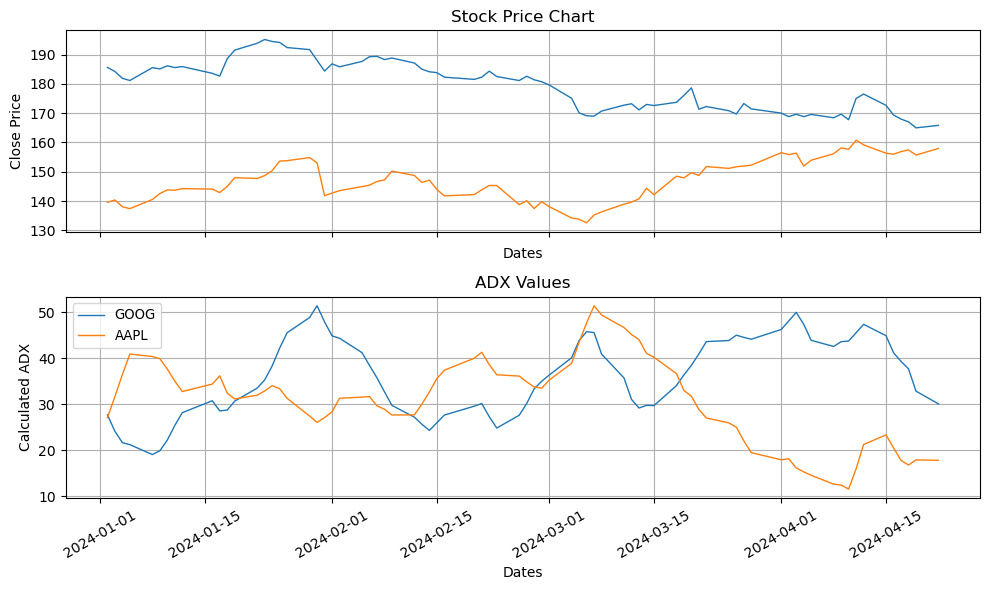

In [17]:
### Plot ADX
# Convert 'Date' column to datetime format
stock_data['Date'] = pd.to_datetime(stock_data['Date'])

# Filter stock_data and mult_adx based on start_date
start_date = pd.Timestamp('2024-01-01')  # Assuming start_date is '2024-01-01'
filtered_stock_data = stock_data2[stock_data2['Date'] >= start_date]
filtered_mult_adx = mult_adx[mult_adx.index.isin(filtered_stock_data.index)]

# Plot Stocks Analyzed
fig = plt.figure(figsize = (10, 6))
ax = fig.add_subplot(2, 1, 1)
ax.set_xticklabels([])
plt.plot(filtered_stock_data['Date'], filtered_stock_data['Close'], lw = 1, label = mult_tick_list)
plt.title('Stock Price Chart')
plt.ylabel('Close Price')
plt.xlabel('Dates')
plt.grid(True)

# Add ADX Subplot
bx = fig.add_subplot(2, 1, 2)
for t in mult_tick_list:
    plt.plot(filtered_stock_data['Date'], filtered_mult_adx[t], lw = 1, label = t)
plt.title('ADX Values')
plt.legend(loc=2, prop={'size': 9.5})
plt.ylabel('Calculated ADX')
plt.xlabel('Dates')
plt.grid(True)
plt.setp(plt.gca().get_xticklabels(), rotation=30)
plt.tight_layout()
plt.show()
